In [1]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
import tensorflow as tf
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16921273280944523297
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3643801600
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8471297926573438815
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
2.10.1


**Data Visualization**

angry
disgust
fear
happy
neutral
sad
surprise


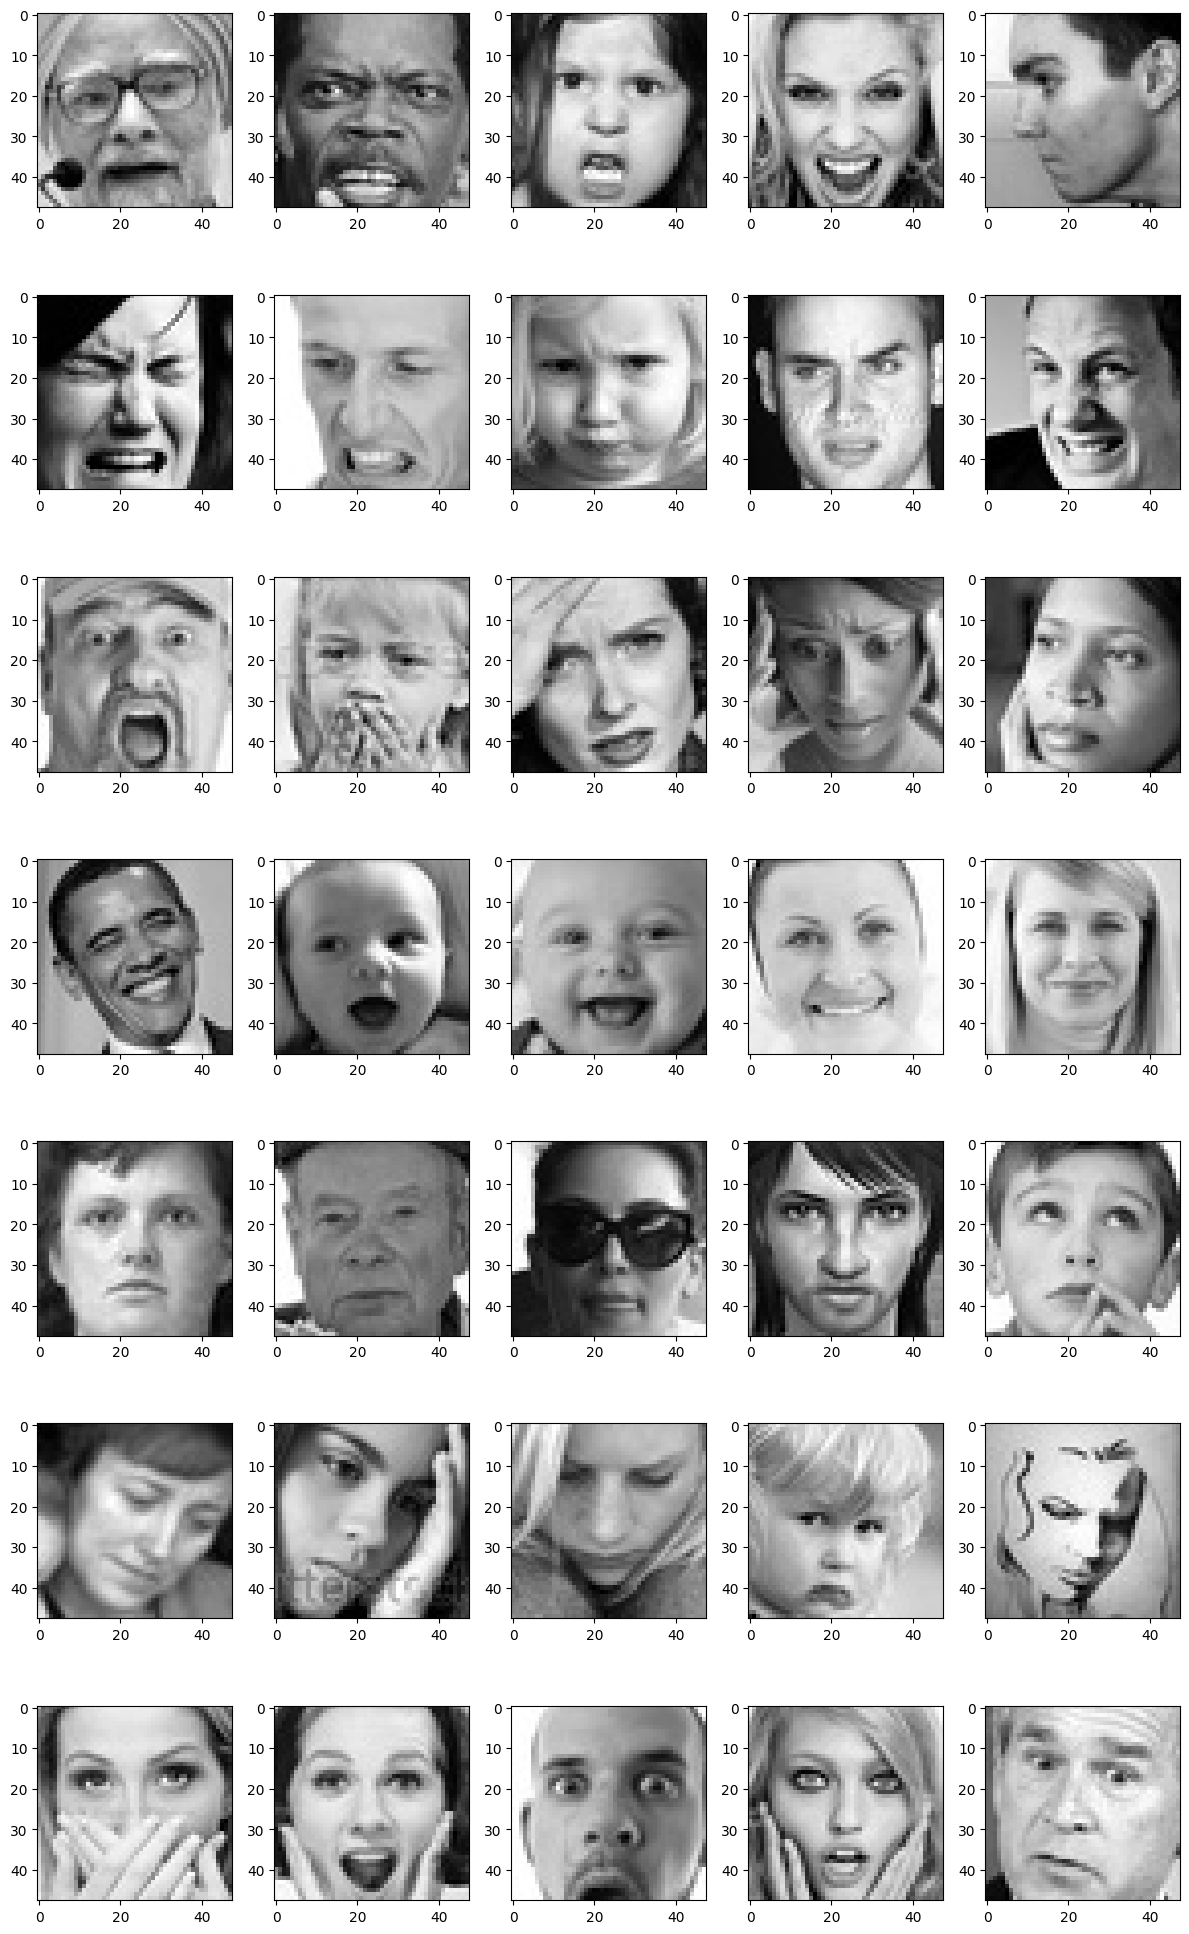

In [2]:
from PIL import Image
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import os
# from keras.preprocessing.image import load_img, img_to_array

emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

img_path_train = '../datasets/train/'
img_path_validation = '../datasets/validation/'
plt.figure(0, figsize=(12,20))
pic_size = 48
cnt = 0
for expression in emotions:
    print(expression)
    for i in range(1,6):
        cnt = cnt + 1
        plt.subplot(7,5,cnt)
        img = Image.open(img_path_train + expression + '/' +os.listdir(img_path_train + expression)[i], 'r')
        plt.imshow(img, cmap="gray")
plt.tight_layout()
plt.show()


**Getting Image and Data Generator**

In [3]:
# building data generator 

from keras.preprocessing.image import ImageDataGenerator

batch_size = 128




train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_generator = train_datagen.flow_from_directory(img_path_train,
                                                    target_size=(56,56),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(img_path_validation,
                                                    target_size=(56,56),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


**Initial Model Experimentation**

In [4]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GlobalMaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications import ResNet50

#Resnet Model Building
model = Sequential()
model.add(ResNet50(input_shape=(pic_size, pic_size, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))


In [5]:
#Fine tuning parameters
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


In [6]:
# number of epochs to train the NN
epochs = 8

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

with tf.device('/gpu:0'):
    history = model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        epochs = epochs,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps = validation_generator.n//validation_generator.batch_size,
                        verbose=0)

C:\Users\Woodkid\AppData\Local\Temp\ipykernel_23448\4185644212.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator,


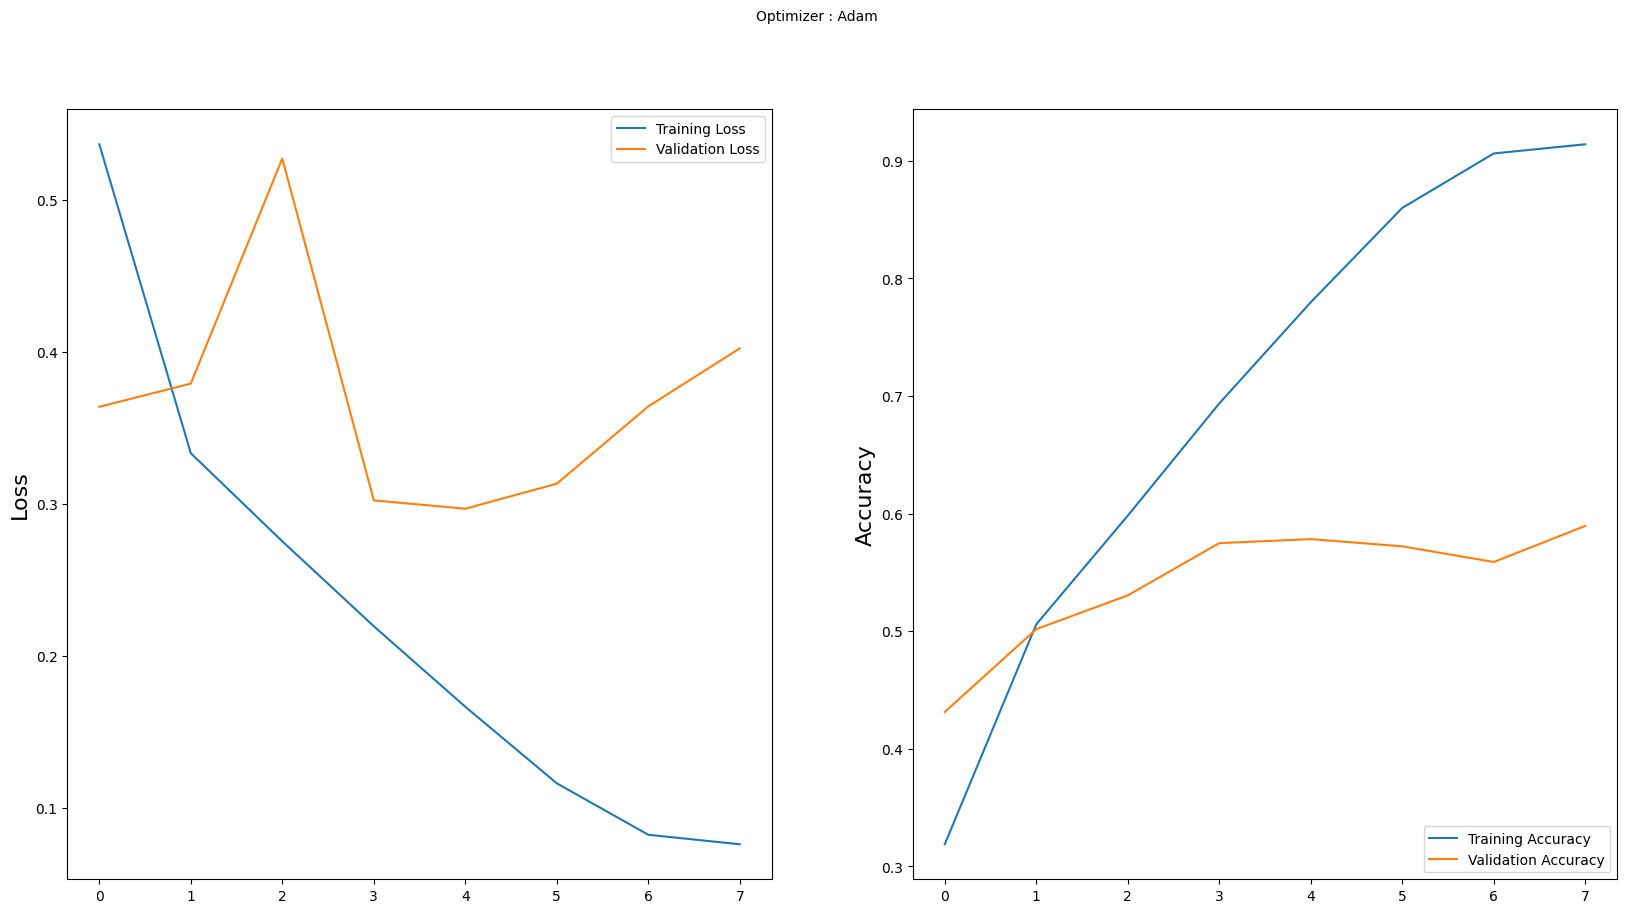

In [7]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

**Changing Optimizer to RMSProp**

In [8]:
#Fine tuning parameters, at same learning rate, try a different optimizer
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


In [9]:
# number of epochs to train the NN
epochs = 10

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

with tf.device('/gpu:0'):
    history = model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        epochs = epochs,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps = validation_generator.n//validation_generator.batch_size,
                        verbose=0)

C:\Users\Woodkid\AppData\Local\Temp\ipykernel_23448\1311544733.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator,


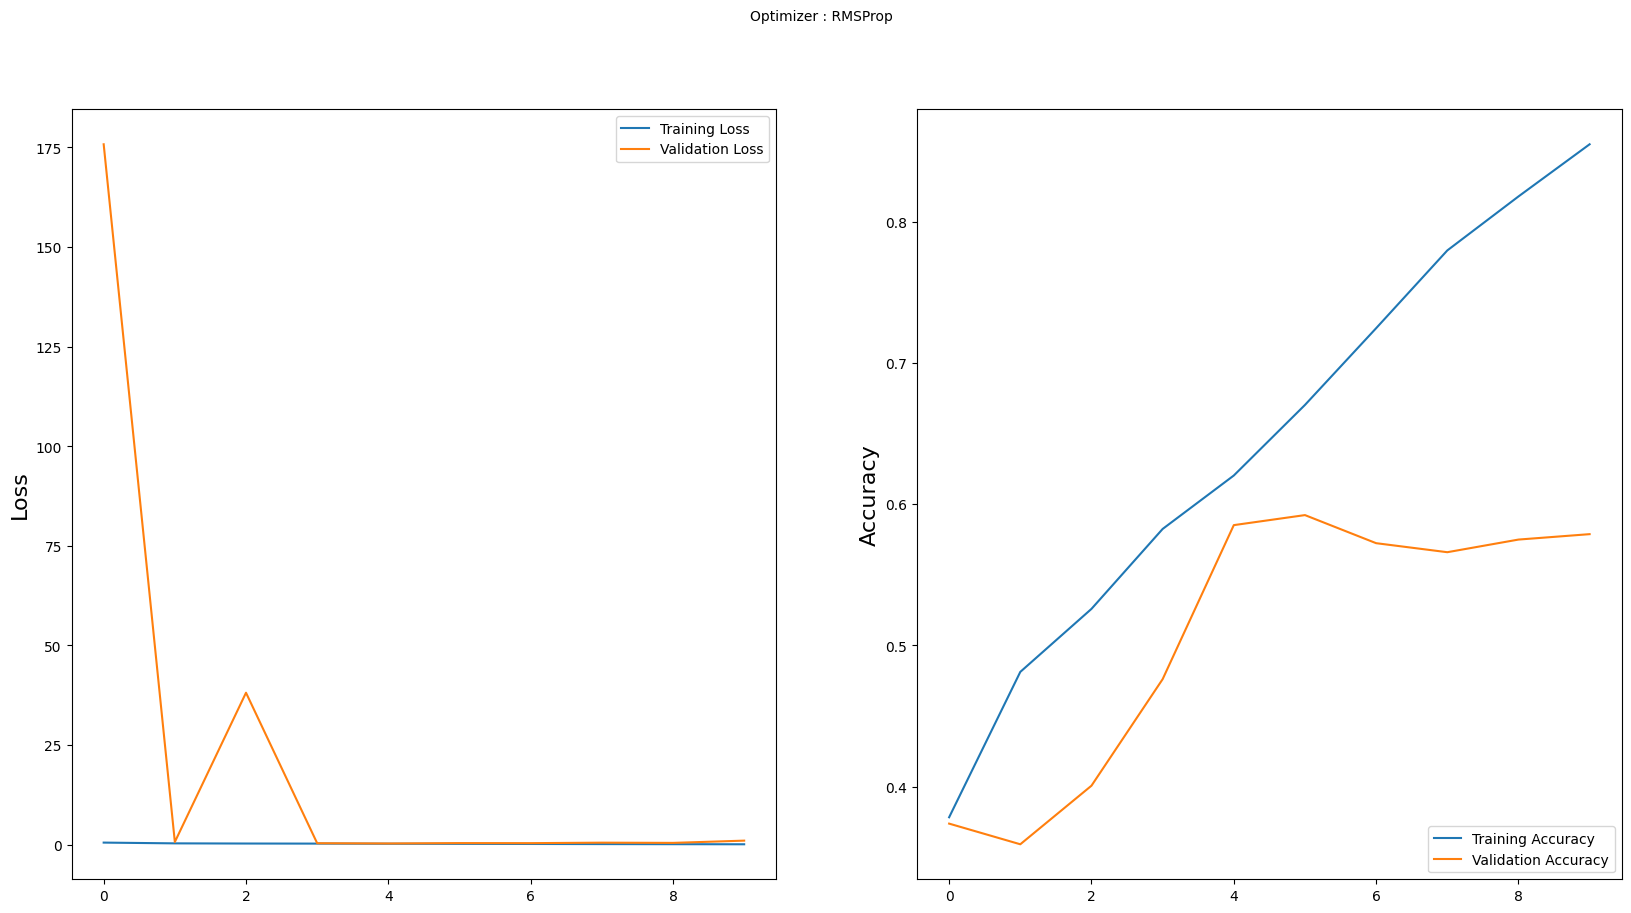

In [10]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : RMSProp', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

**Changing Optimizer to Nadam**

In [11]:
#Fine tuning parameters, at same learning rate, try a different optimizer
from keras.optimizers import Nadam
model.compile(optimizer=Nadam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


In [12]:
# number of epochs to train the NN
epochs = 10

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

with tf.device('/gpu:0'):
    history = model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        epochs = epochs,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps = validation_generator.n//validation_generator.batch_size,
                        verbose=0)

C:\Users\Woodkid\AppData\Local\Temp\ipykernel_23448\1311544733.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator,


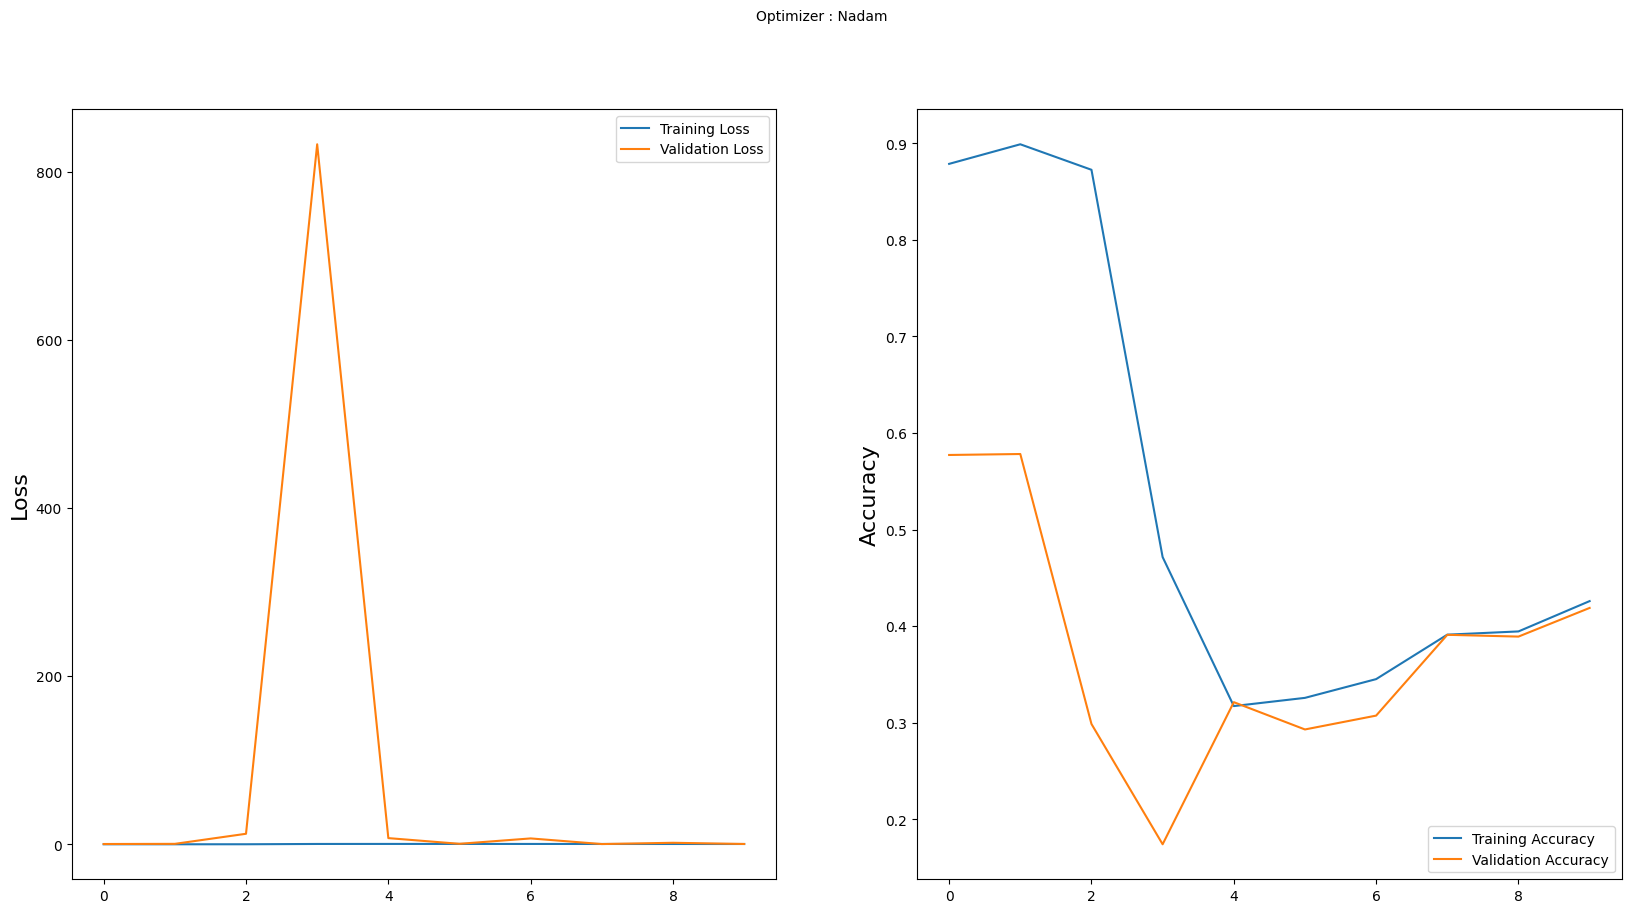

In [13]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Nadam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

Nadam seems to suffer from the overfitting issue as well, so Adam is still the best option we have for now.

**Trying other Pre-trained Model on Tensorflow: VGG16**

In [14]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GlobalMaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications import VGG16

#Resnet Model Building
model = Sequential()
model.add(VGG16(input_shape=(pic_size, pic_size, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))


58889256/58889256 [==============================] - 2s 0us/step


In [15]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 512)              0         
 balMaxPooling2D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 14,718,279
Trainable params: 14,718,279
Non-trainable params: 0
_________________________________________________________________


In [16]:
# number of epochs to train the NN
epochs = 8

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

with tf.device('/gpu:0'):
    history = model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        epochs = epochs,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps = validation_generator.n//validation_generator.batch_size,
                        verbose=0)

C:\Users\Woodkid\AppData\Local\Temp\ipykernel_23448\4185644212.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator,


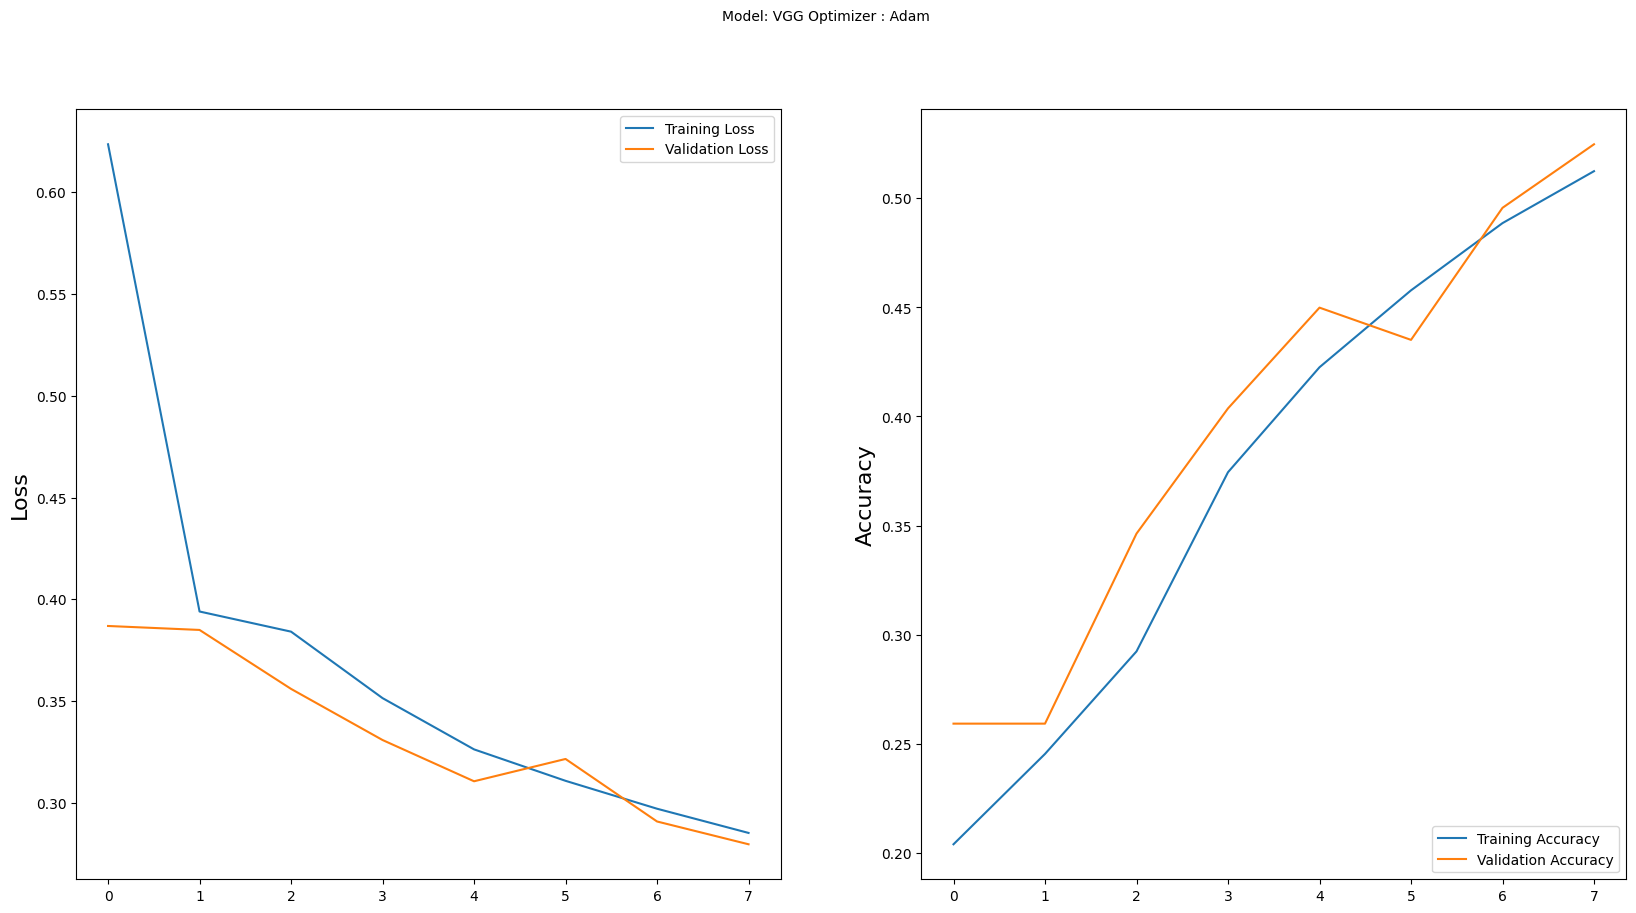

In [17]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Model: VGG Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

**Trying other Pre-trained Model on Tensorflow: MobileNetV2**

In [18]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GlobalMaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications import MobileNetV2

#Resnet Model Building
model = Sequential()
model.add(MobileNetV2(input_shape=(pic_size, pic_size, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))

9406464/9406464 [==============================] - 1s 0us/step


In [19]:
#Fine tuning parameters, increase learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d_2 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 7)                 8967      
                                                                 
Total params: 2,266,951
Trainable params: 2,232,839
Non-trainable params: 34,112
_________________________________________________________________


In [20]:
# number of epochs to train the NN
epochs = 8

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

with tf.device('/gpu:0'):
    history = model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        epochs = epochs,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps = validation_generator.n//validation_generator.batch_size,
                        verbose=0)

C:\Users\Woodkid\AppData\Local\Temp\ipykernel_23448\4185644212.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator,


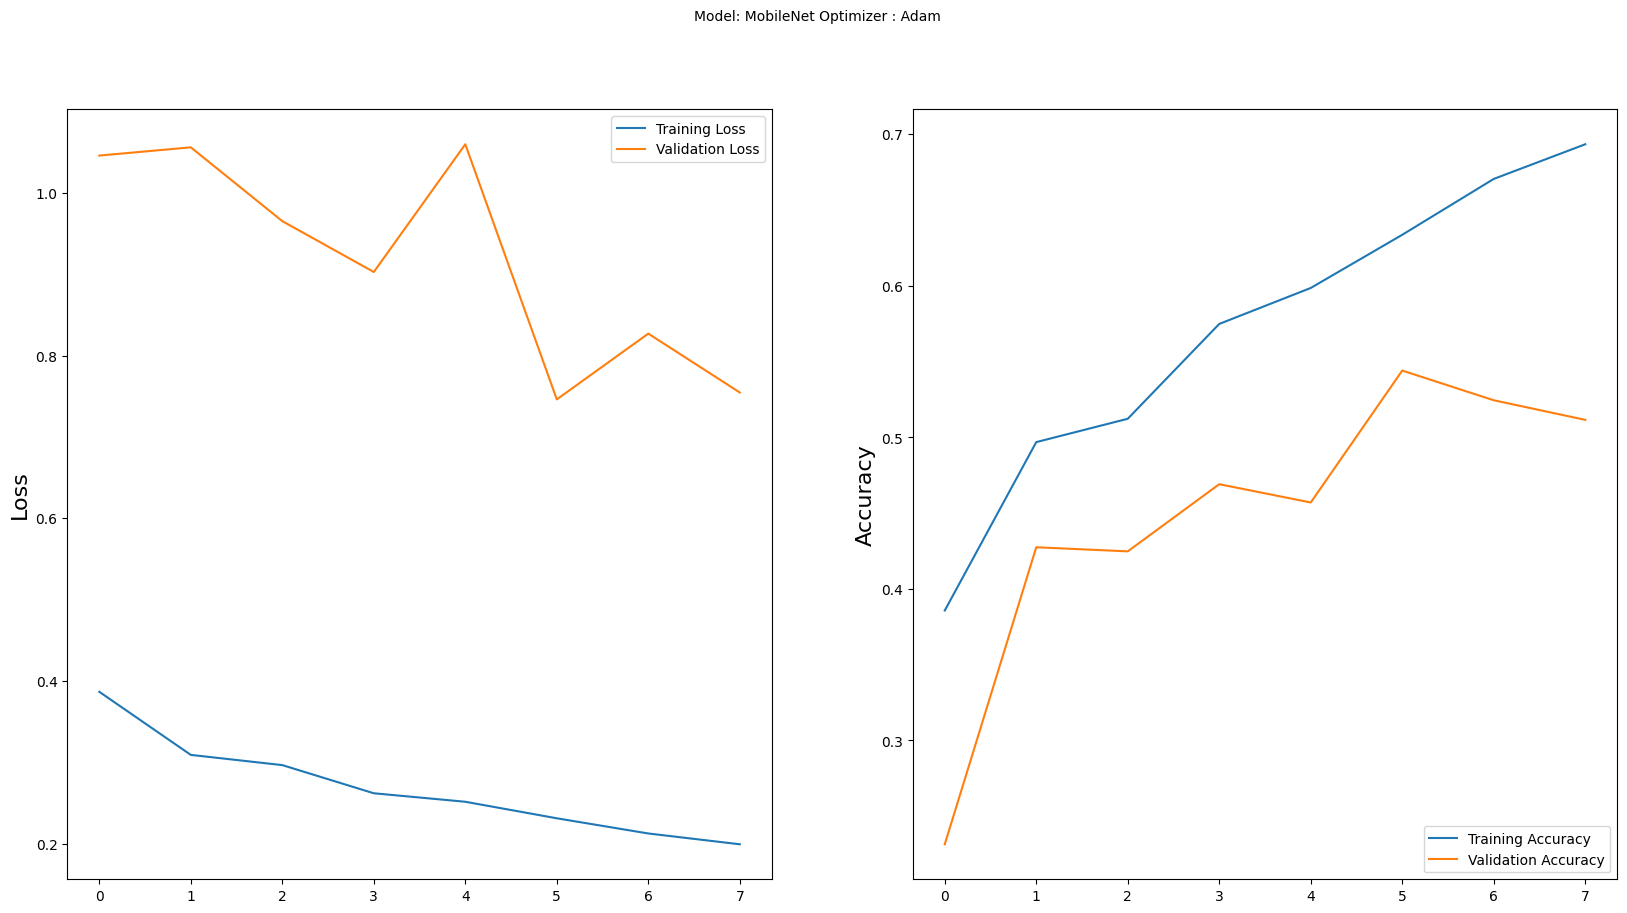

In [21]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Model: MobileNet Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

**Optimized Resnet**

In [29]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GlobalMaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications import ResNet50
from keras.utils.vis_utils import plot_model

#Resnet Model Building
model = Sequential()
model.add(ResNet50(input_shape=(pic_size, pic_size, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))


In [30]:
#Fine tuning parameters, increase learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d_4 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 7)                 14343     
                                                                 
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


In [31]:
# number of epochs to train the NN
epochs = 25

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

with tf.device('/gpu:0'):
    history = model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        epochs = epochs,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps = validation_generator.n//validation_generator.batch_size,
                        verbose=0)

C:\Users\Woodkid\AppData\Local\Temp\ipykernel_23448\1052541402.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator,


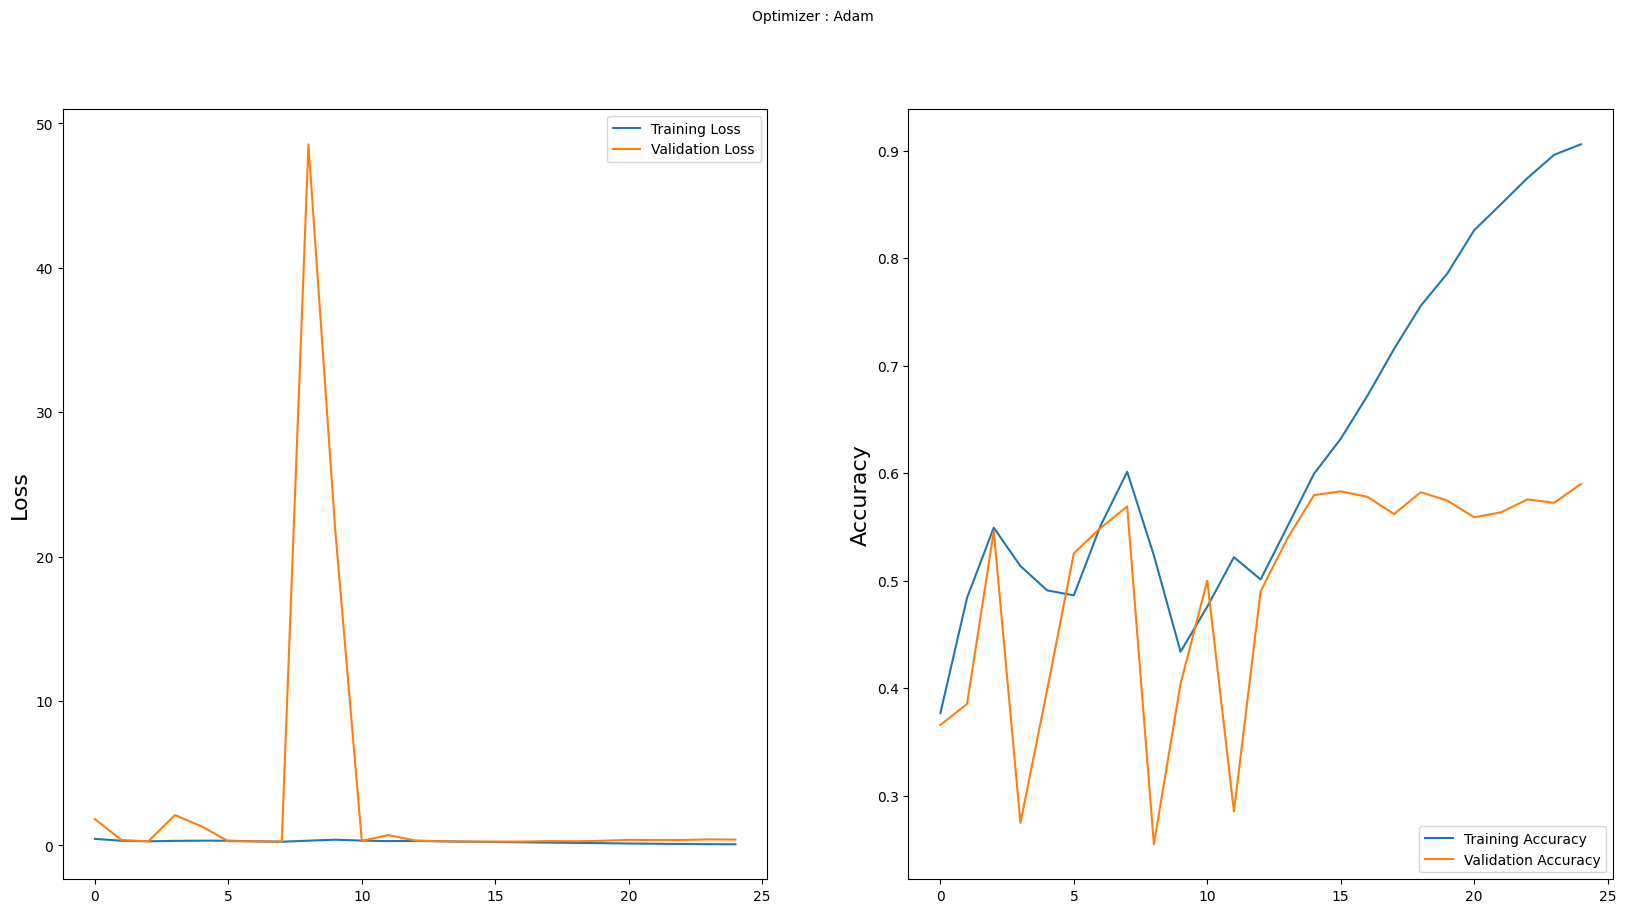

In [25]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

**For Dynamic Facial Expression Recognition**

In [35]:
#Saving the  model to  use it later on
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("resnet1.h5")

**Performance Analysis**

In [27]:
loss = model.evaluate(validation_generator)
print('Test loss:', loss)

56/56 [==============================] - 3s 46ms/step - loss: 0.3974 - accuracy: 0.5900
Test loss: [0.39739760756492615, 0.5900084972381592]


In [37]:
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

56/56 [==============================] - 3s 51ms/step


<Figure size 640x480 with 0 Axes>

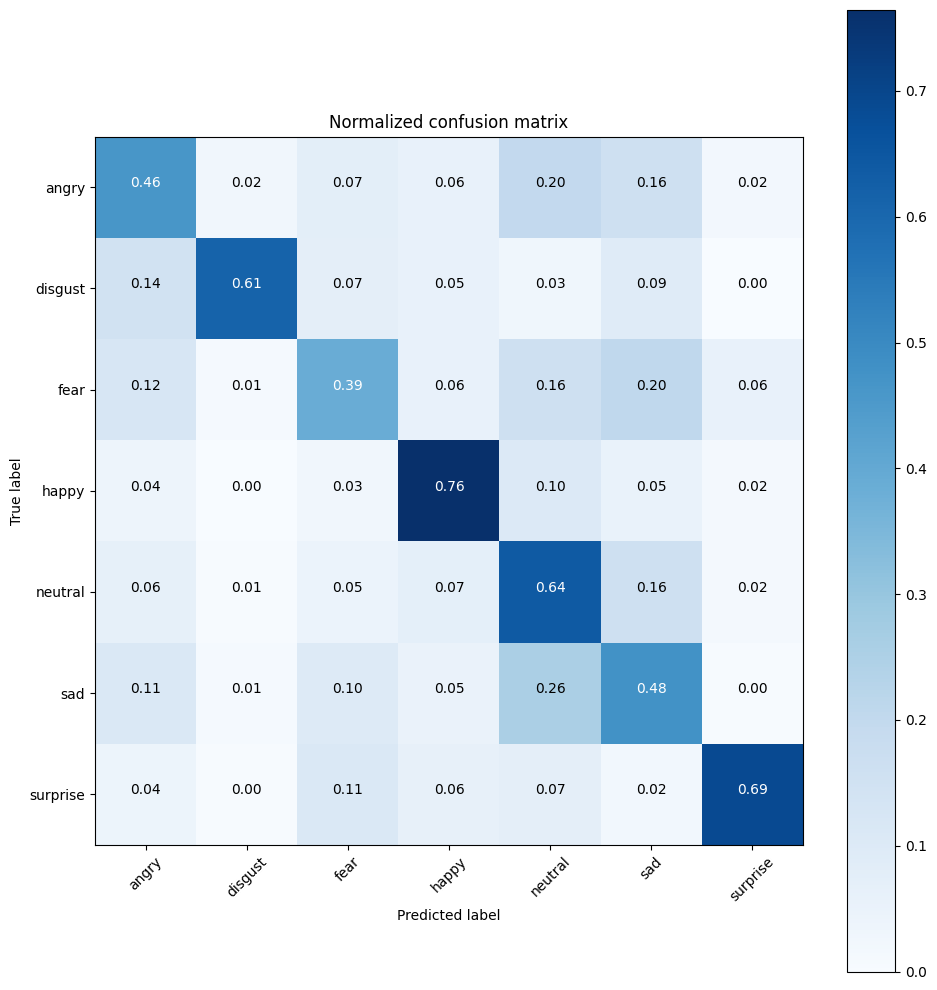

In [38]:
from sklearn.metrics import confusion_matrix
# compute confusion matrix
predictions = model.predict(validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

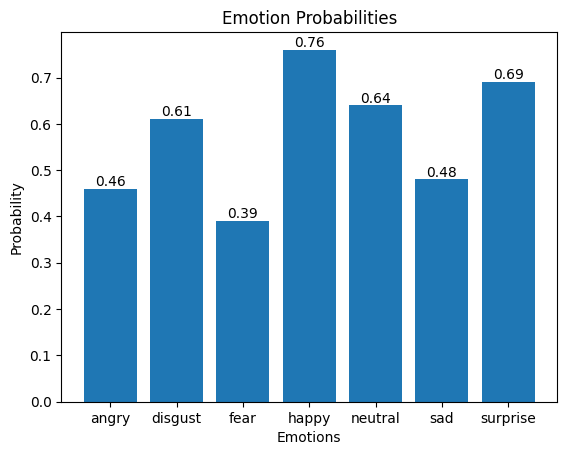

In [40]:
import matplotlib.pyplot as plt

# Data
features = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
probabilities = [0.46, 0.61, 0.39, 0.76, 0.64, 0.48, 0.69]

# Create a bar chart
bars = plt.bar(features, probabilities)

# Set the title and axis labels
plt.title("Emotion Probabilities")
plt.xlabel("Emotions")
plt.ylabel("Probability")

# Add numerical values on top of each bar
for bar, probability in zip(bars, probabilities):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{probability:.2f}",
        ha="center",
        va="bottom",
    )

# Show the chart
plt.show()